In [3]:
"""
run_bayesian.py
Python script to run Bayesian analysis for DIUSST model
"""

# Change working directory to curr
import os

# Load external modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from multiprocessing import Pool
from multiprocessing import cpu_count

# Load custom functions
from interpolation import cfl_interpolation
from diusst_model import diusst_bayesian as diusst

# Time stamp
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%y%m%d-%H%M%S")

In [4]:
###########################################################
# RUN SETTINGS (check before each run)

# Output storage
run_id = 'M-I2-A2'
output_path = '../output/'

# Fit parameters
param_names = ['kappa', 'mu', 'attenu']

# Parameter limits
param_min = np.array([0, 0, 1e-3])
param_max = np.array([7e-4, 0.1, 10])

# Initial walker positions
param_start = np.array([2e-4, 1e-4, 2.5])

# Sampling
nwalkers = 16
nsteps = 2500

# DIUSST model
scheme = 'euler'
dz0 = 0.05
ngrid = 80
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

# Dataset
data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_ssterr03-10_humid10.csv'
data_interval = [786,1377]

# Other settings
parallel = True
use_backend = True

###########################################################
# (End of run settings)
###########################################################

In [5]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[data_interval[0]:data_interval[1]]

# interpolate to meet CFL condition
data, dtlist = cfl_interpolation(data_orig, dz0=dz0, ngrid=ngrid,
        a=0, b=1, k_eddy_max=param_max[0], maxwind=maxwind,)
        #save=output_path+timestamp+'_'+run_id)

NameError: name 'cfl_interpolation5' is not defined

In [4]:
data_orig

,times,sst,sst_err,ftemp,wind,atemp,swrad,humid
786,691337.04,303.137,1.0,303.484,1.492,302.197,0.5,0.01
787,692022.96,303.126,1.0,303.508,1.029,302.257,0.5,0.01
788,692717.04,303.142,1.0,303.498,0.709,302.219,0.5,0.01
789,693402.72,303.127,1.0,303.509,0.434,302.162,0.5,0.01
790,694097.04,303.132,1.0,303.456,0.682,302.225,0.7,0.01
...,...,...,...,...,...,...,...,...
1372,1119935.04,299.239,1.0,297.522,5.100,299.192,0.8,0.01
1373,1120634.64,299.456,1.0,299.688,5.360,299.461,1.0,0.01
1374,1121343.12,299.515,1.0,299.059,5.302,299.187,1.3,0.01
1375,1122042.84,298.786,1.0,298.827,5.738,299.145,0.7,0.01


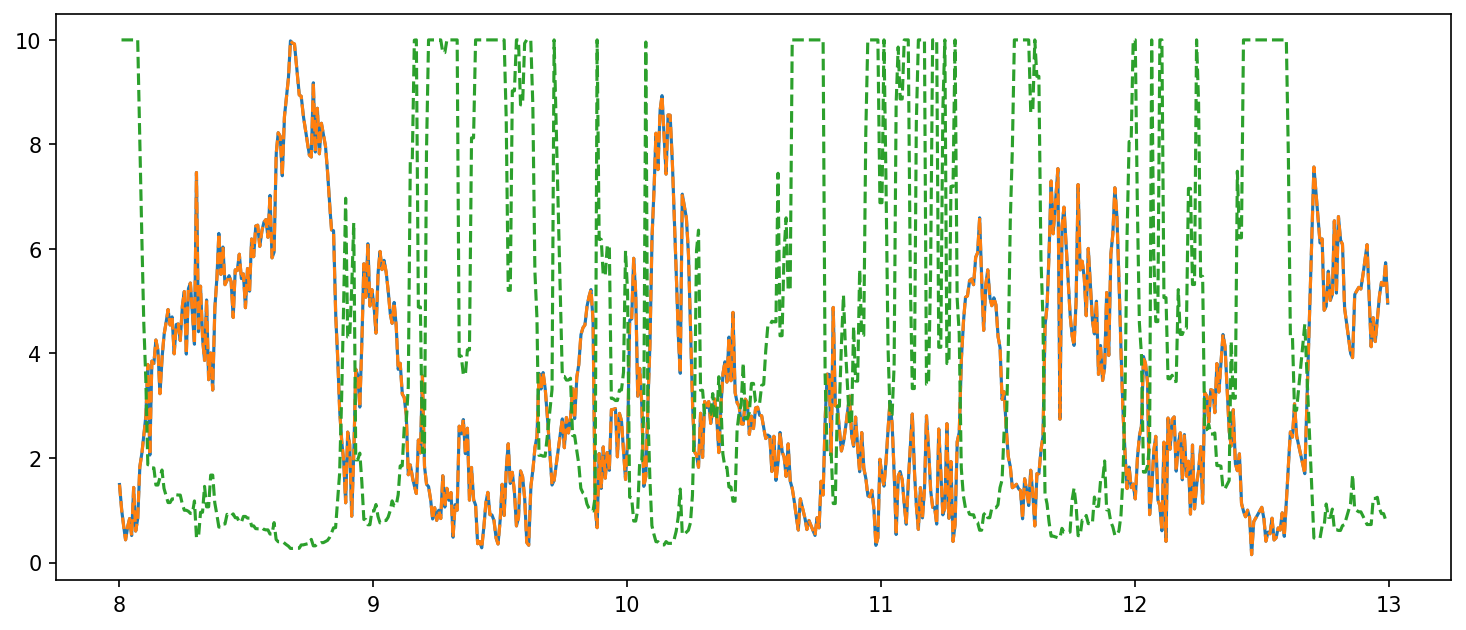

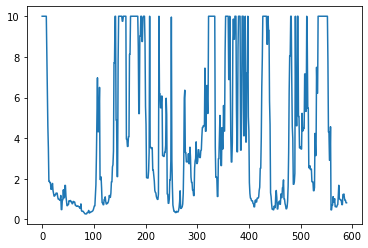

In [5]:
fig, ax = plt.subplots(dpi=150,figsize=(12,5))
ax.plot(data['times']/86400,data['wind'])
ax.plot(data_orig['times']/86400,data_orig['wind'],'--')
ax.plot(data_orig['times'][1:]/86400,dtlist,'--')
plt.show()

fig, ax = plt.subplots()
ax.plot(dtlist)

In [6]:
# extract data
ftemp = data['ftemp'].to_numpy(np.float64)
sst_data = data['sst'].to_numpy(np.float64) - ftemp
sst_err = data['sst_err'].to_numpy(np.float64)
times = data['times'].to_numpy(np.float64)
wind = data['wind'].to_numpy(np.float64)
atemp = data['atemp'].to_numpy(np.float64)
swrad = data['swrad'].to_numpy(np.float64)
humid = data['humid'].to_numpy(np.float64)

In [18]:
import time
simstart = time.time()

kappa, mu, attenu = param_start
#kappa, mu, attenu = param_min[0], 0.1, param_min[2]
kappa = 7e-4
mu = 1e-1
attenu=1
simu = diusst(
            times, atemp, ftemp, swrad, u_data=wind, sa_data=humid,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

10.118798017501831


[Text(0.5, 1.0, 'SST-ftemp')]

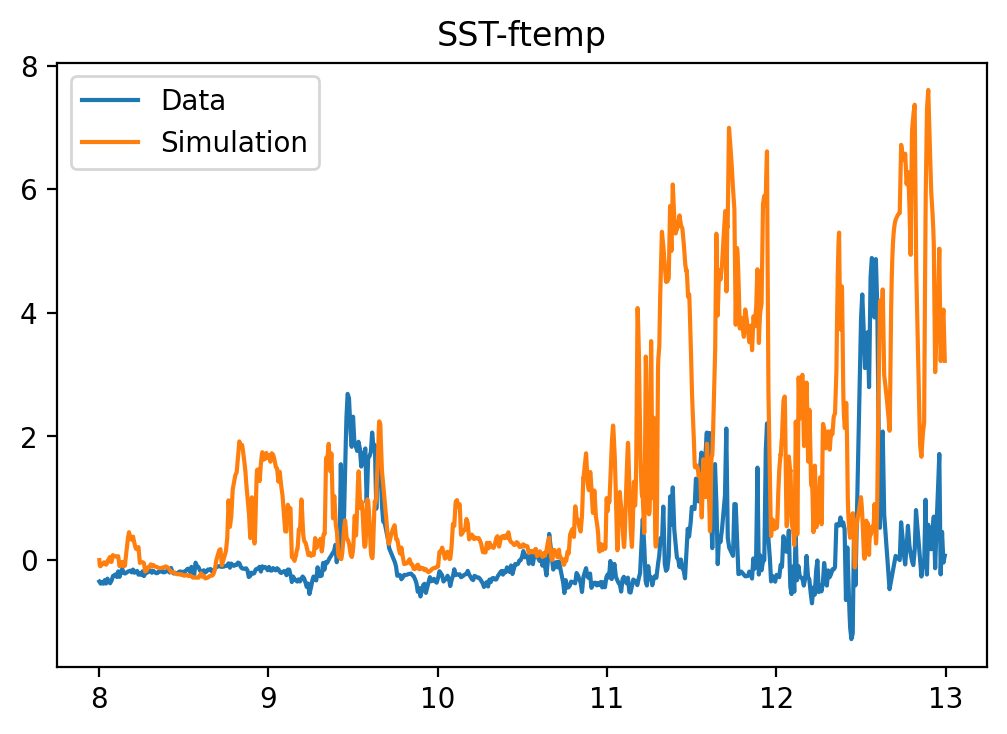

In [22]:
fig, ax = plt.subplots(dpi=200)
ax.plot(times/86400,sst_data, label='Data')
ax.plot(times/86400,simu[0][:,0]-ftemp,label='Simulation')
ax.legend()
ax.set(title='SST-ftemp')

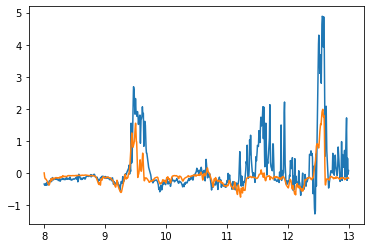

In [33]:
plt.plot(times/86400,sst_data)
plt.plot(times/86400,simu[0][:,0]-ftemp)
#plt.plot(times/86400,simu[0][:,3]-ftemp)

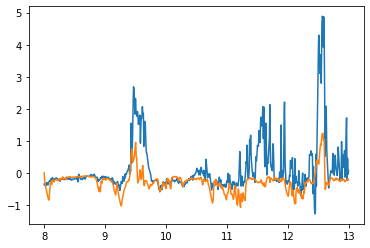

In [31]:
plt.plot(times/86400,sst_data)
plt.plot(times/86400,simu[0][:,0]-ftemp)
#plt.plot(times/86400,simu[0][:,3]-ftemp)

In [13]:
sst_model = simu[0][:,0]
print(np.mean(((sst_data-sst_model)/sst_err)**2))
print(np.exp(-np.mean(((sst_data-sst_model)/sst_err)**2)))
print(np.exp(-np.inf))

745398.4299192774
0.0
0.0


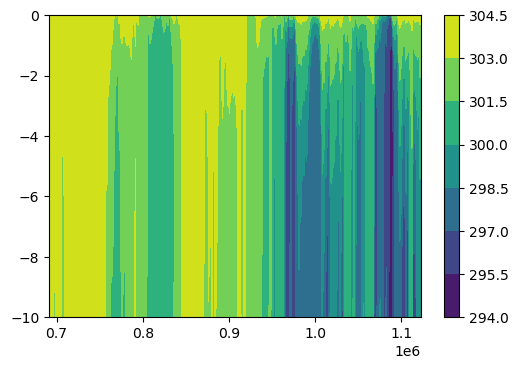

In [12]:
fig, ax = plt.subplots(dpi=100)
plot = ax.contourf(times,simu[1],simu[0].transpose())
fig.colorbar(plot)

In [15]:
ftemp

301.0194977362443

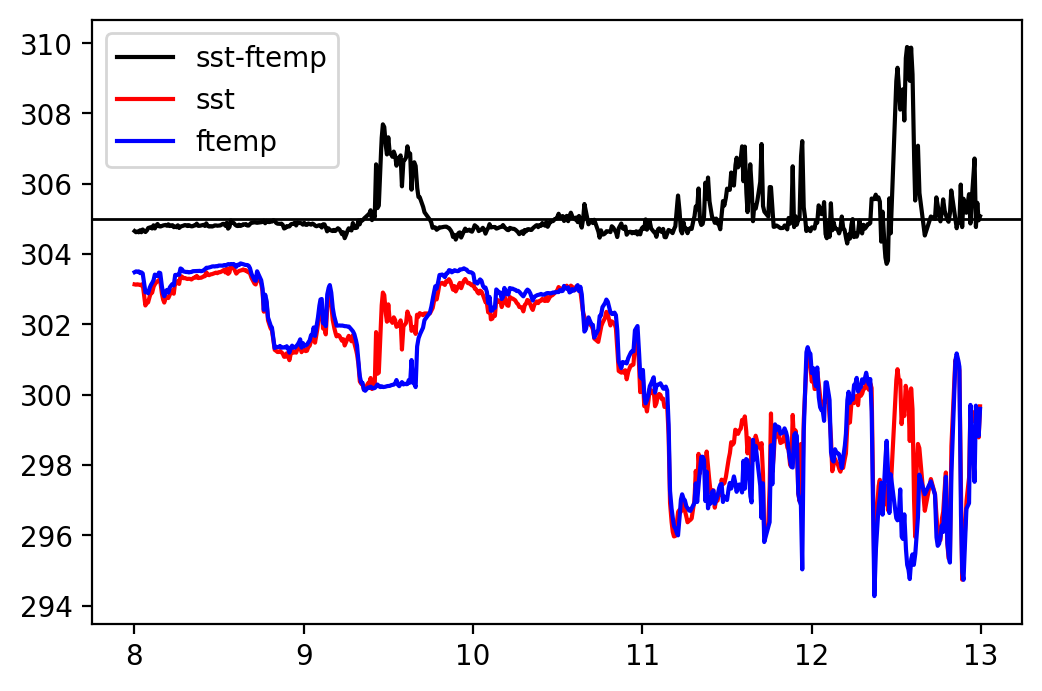

In [32]:
fig, ax = plt.subplots(dpi=200)
ax.plot(times/86400,sst_data+305,c='k',label='sst-ftemp')
ax.axhline(y=305,c='k',lw=1)
ax.plot(times/86400,sst_data+ftemp,c='red',label='sst')
ax.plot(times/86400,data['ftemp'],c='blue',label='ftemp')
ax.legend()
#plt.plot(times,simu[0][:,-1])

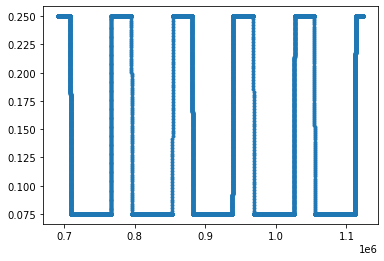

In [28]:
plt.plot(times,data['sst_err']*0.25,'.')

In [17]:
from diusst_funcs import make_mesh

In [18]:
make_mesh(0.05,80)

(array([  0.05      ,   0.        ,  -0.05      ,  -0.10103241,
         -0.15311856,  -0.20628019,  -0.26053951,  -0.3159192 ,
         -0.37244238,  -0.43013267,  -0.48901416,  -0.54911145,
         -0.61044964,  -0.67305436,  -0.73695176,  -0.80216853,
         -0.86873191,  -0.93666971,  -1.00601031,  -1.07678267,
         -1.14901635,  -1.22274153,  -1.29798902,  -1.37479023,
         -1.45317725,  -1.53318282,  -1.61484038,  -1.69818401,
         -1.78324855,  -1.87006953,  -1.9586832 ,  -2.0491266 ,
         -2.14143749,  -2.23565444,  -2.33181681,  -2.42996476,
         -2.53013929,  -2.63238226,  -2.73673636,  -2.8432452 ,
         -2.95195325,  -3.06290594,  -3.17614961,  -3.29173156,
         -3.40970008,  -3.53010444,  -3.65299494,  -3.77842292,
         -3.90644077,  -4.03710196,  -4.17046108,  -4.30657383,
         -4.44549707,  -4.58728883,  -4.73200835,  -4.87971607,
         -5.0304737 ,  -5.18434421,  -5.34139188,  -5.50168231,
         -5.66528246,  -5.83226066,  -6.